In [1]:
LOCAL_RUN = True

# Problem Definition
The following notebook is intended to create the training data for enabling an image classifier to be able to give a relatedness score between any two images. Namely, given two images **a** and **b** the classifier should be training to handle the following cases:

1. **a** is the same product as **b**
2. **a** is a similar product to **b** but different 
3. **a** is completely different to **b**

The problem is that we are given a list of images and their corresponding classes (about 11k) so negative (unrelated) examples are plentiful but related examples are sparse. Some of these problems can be mitigated with data augmentation and data balancing. However, the problem this notebook solves is that of **carefully choosing meaningful negative examples to complement the positive ones.**

In [2]:
# from google.colab import drive
import os
import pandas as pd
import numpy as np
from meta.paths import PATH_TO_DATA
from preprocessing.image_pair_creator import train_test_split_no_stratification

In [3]:
if not LOCAL_RUN:
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/csc566-images/
    PATH_TO_DATA = "."

# 1. Import Training Data

In [4]:
path_to_training_data = os.path.join(PATH_TO_DATA, "train.csv")
df = pd.read_csv(path_to_training_data)
df['target'] = df.label_group.map(df.groupby('label_group').posting_id.agg('unique').to_dict())
df['oof'] = df.image_phash.map(df.groupby('image_phash').posting_id.agg('unique').to_dict())
df['target'] = df['target'].apply(list)
df.head()

,posting_id,image,image_phash,title,label_group,target,oof
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413]


# 2. Split Images into Test and Train

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split_no_stratification(df, 0.1) # minimum percentage to cover all possible classes

In [6]:
# test_groups = x_test["label_group"].unique()
# train_groups = x_train["label_group"].unique()
# groups_missing_in_train = [test_g for test_g in test_groups if test_g not in train_groups]
# assert len(groups_missing_in_train) == 0

In [7]:
x_train.to_csv(os.path.join(PATH_TO_DATA, "subset_train.csv"), index=False)
x_test.to_csv(os.path.join(PATH_TO_DATA, "subset_test.csv"), index=False)

# 3. Create Image Pairs
This section is responsible for creating a set of *useful* image pairs from the training images.
It is inevitable that the number of unrelated image pairs far exceeds the number of related image pairs. Therefore,
in our quest we require an **roughly** equal number of related and unrelated image pairs, we are faced with selecting only a subset of all negative pairs. In theory these can be choosen randomly or psuedo-randomly, of which we opt for the latter. Namely, we select negative pairs by selecting the images whose posts titles have the highest similarity using a TfidfVectorizer trained on the all titles.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from preprocessing.image_pair_creator import calculate_title_similarities, create_negative_pairs, create_positive_pairs

from meta.paths import PATH_TO_TEST_PAIRS, PATH_TO_TRAIN_PAIRS

In [9]:
def oversample_data(data_df, n_items):
    current_n_items = len(data_df)
    n_full_copies = n_items // current_n_items
    n_remaining = n_items % current_n_items
    balanced_df = data_df
    for i in range(n_full_copies-1):
        balanced_df = pd.concat([balanced_df, data_df], axis=0)
    return pd.concat([balanced_df, data_df.sample(n=n_remaining)], axis=0)

### Training Data

In [10]:
negative_examples_df = create_negative_pairs(x_train)
positive_examples_df = create_positive_pairs(x_train)
train_image_pairs_df = pd.concat([oversample_data(positive_examples_df, len(negative_examples_df)),
                                  negative_examples_df], axis=0)
print(len(train_image_pairs_df))
train_image_pairs_df.to_csv(PATH_TO_TRAIN_PAIRS, index=False)
train_image_pairs_df.head()

163768


,class_label,source_image,target_image,type
0,1.0,0000a68812bc7e98c42888dfb1c07da0.jpg,0000a68812bc7e98c42888dfb1c07da0.jpg,RELATED
1,1.0,0000a68812bc7e98c42888dfb1c07da0.jpg,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,RELATED
2,1.0,00039780dfc94d01db8676fe789ecd05.jpg,00039780dfc94d01db8676fe789ecd05.jpg,RELATED
3,1.0,00039780dfc94d01db8676fe789ecd05.jpg,8cbe4bf9706bc177fd61071ef776be8c.jpg,RELATED
4,1.0,000a190fdd715a2a36faed16e2c65df7.jpg,000a190fdd715a2a36faed16e2c65df7.jpg,RELATED


### Testing Data

In [11]:
test_negative_pairs = create_negative_pairs(x_test)
test_positive_pairs = create_positive_pairs(x_test)
test_pairs_df = pd.concat([test_positive_pairs,
                                  test_negative_pairs], axis=0)
print(len(test_pairs_df))
test_pairs_df.to_csv(PATH_TO_TEST_PAIRS, index=False)
test_pairs_df.head()

9355


,class_label,source_image,target_image,type
0,1.0,00286d2760e433a8a01cbd9e056144f7.jpg,00286d2760e433a8a01cbd9e056144f7.jpg,RELATED
1,1.0,00286d2760e433a8a01cbd9e056144f7.jpg,97e85263a67b84318bfc4b79236fcd4e.jpg,RELATED
2,1.0,00324695e37299a00b955674d984592b.jpg,00324695e37299a00b955674d984592b.jpg,RELATED
3,1.0,00324695e37299a00b955674d984592b.jpg,d668555c06a1b97d98d0a20f028e9694.jpg,RELATED
4,1.0,005a507afe7092537e4c6243c4e0d790.jpg,005a507afe7092537e4c6243c4e0d790.jpg,RELATED


 # Dataset Statistics
 * What is the distribution of classes?
 * What does each class and their variants look like (e.g. related, similar, and not similar)

In [12]:
from matplotlib import pyplot as plt

### Training Data

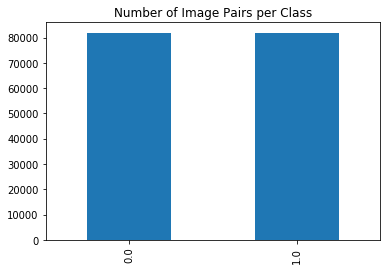

In [13]:
train_image_pairs_df["class_label"].value_counts().plot.bar(title='Number of Image Pairs per Class')

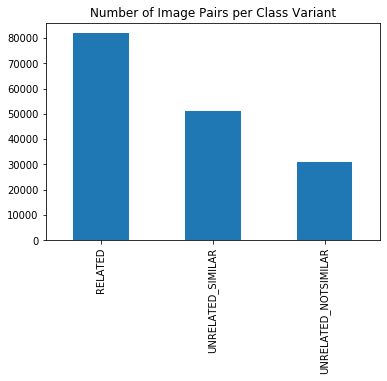

In [14]:
train_image_pairs_df["type"].value_counts().plot.bar(title='Number of Image Pairs per Class Variant')

### Testing Data

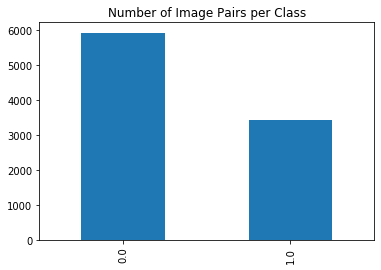

In [15]:
test_pairs_df["class_label"].value_counts().plot.bar(title='Number of Image Pairs per Class')

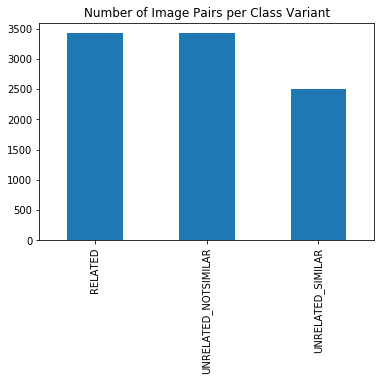

In [16]:
test_pairs_df["type"].value_counts().plot.bar(title='Number of Image Pairs per Class Variant')